This notebook follows from rotate_no_resize_inference and running the nn-Unet model. It is used to find the Dice and sDice metric results. This script is to calculate the DICE, sDICE, and the Hausdorff distance of two sets of labels. The sets of labels are called (a) original for the manual labels and (b) predicted for the predicted labels
Documentation of metrics can be found here: https://github.com/deepmind/surface-distance


In [1]:
#Necessary imports
import os
import shutil

from ast import Break
import os
import SimpleITK as sitk
import numpy as np

import re

from absl.testing import absltest
from absl.testing import parameterized
import surface_distance
from surface_distance import metrics

import pandas as pd
import matplotlib.pyplot as plt


Set all necessary paths

In [2]:
nnUnet_res= '/home/chloe/nnUNet_Results/Task603_SettingUp_Res' #Change to your nnUnet result path
predicted_labels = 'results/transformed_results/predicted_labels'
rot_dir = 'results/transformed_results/transformed_images'

# Define the path to where you store transformed data and where to store nnUnet data
transform_label_dir = 'results/transformed_results/transformed_labels'
stored_label_folder = 'results/transformed_results/stored_transformed_labels'


Copy the results to the current working directory

In [3]:
#Maybe add to only move image outputs

file_names = os.listdir(nnUnet_res)
rot_names = os.listdir(rot_dir)
    
for file_name in file_names:
    for rot in rot_names:
        stored_rot_path = os.path.join(predicted_labels,rot)
        print(stored_rot_path)
        if not os.path.exists(stored_rot_path):
            os.makedirs(stored_rot_path)
        if file_name.endswith(rot+".nii.gz"):
            shutil.copy(os.path.join(nnUnet_res, file_name), stored_rot_path)


Move transformed manual labels into folder for computing Dice and sDice metrics

In [4]:
# Code to move transformed data from subfolders to single folder
rot_list = os.listdir(transform_label_dir) 

for rot in rot_list:
    stored_rot_path = os.path.join(stored_label_folder,rot)
    if not os.path.exists(stored_rot_path):
        os.makedirs(stored_rot_path)
    rot_path = os.path.join(transform_label_dir, rot)
    patient_names = os.listdir(rot_path)
    for patient in patient_names:
        patient_path = os.path.join(rot_path, patient)
        image_names = os.listdir(patient_path)
        for image in image_names:
            image_path = os.path.join(patient_path, image)
            shutil.copy(image_path, stored_rot_path)

Give names for predicted labels and rotated manual labels

In [5]:
#Loop over all the rotations
original_label_path = stored_label_folder 
predicted_label_path = predicted_labels

Set initial values and functions

In [6]:
def generate_np_array_of_single_structure(np_matrix, number):
    single_struct_array = np.where(np_matrix != number, 0, np_matrix)
    return single_struct_array.astype('bool')    # sets all 0-entries to False, and all others to True

def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)

num_structures = 1 + 1
s_dice_tolerance = 2 #mm

In [7]:
import re


rot_list = sorted_alphanumeric(os.listdir(predicted_label_path) )
print(rot_list)
#for rot in rot_list:


rot_list = (os.listdir(predicted_label_path) ).sort()
print(rot_list)

['0.0_0.0_0.0', '0.0_0.0_5.0', '0.0_0.0_10.0', '0.0_0.0_15.0', '0.0_0.0_20.0', '0.0_0.0_25.0', '0.0_0.0_30.0', '0.0_0.0_-5.0', '0.0_0.0_-10.0', '0.0_0.0_-15.0', '0.0_0.0_-20.0', '0.0_0.0_-25.0', '0.0_0.0_-30.0']
None


Iterate over file paths to obtain the metric

In [8]:
dice_matrix = np.zeros(num_structures)
hd_matrix = np.zeros(num_structures)
avg_surface_d_matrix = np.zeros(num_structures)
surf_dice_matrix = np.zeros(num_structures)

num_patients = 0
all_numbers = []
for i in range(num_structures):
    all_numbers.append(i)
print("all_numbers: ", all_numbers)

rot_list =  sorted_alphanumeric(os.listdir(predicted_label_path))
first_file_list = sorted_alphanumeric(os.listdir(os.path.join(original_label_path, rot_list[0])))

dice_array = np.zeros(((len(rot_list)), (len(first_file_list)))) #(rows, columns)
sdice_array = np.zeros(((len(rot_list)), (len(first_file_list)))) #(rows, columns)

rot_count = -1

for rot in rot_list:
    rot_count = rot_count + 1
    rot_pred_path = os.path.join(predicted_label_path, rot)
    rot_orig_path = os.path.join(original_label_path, rot)
    file_count = -1
    for filename in sorted_alphanumeric(os.listdir(rot_pred_path)):
        print("Predicting", filename)
        file_count = file_count + 1
        num_patients += 1
        dice_arr = np.zeros(num_structures)
        hd_arr = np.zeros(num_structures)
        avg_surface_d_arr = np.zeros(num_structures)
        surf_dice_arr = np.zeros(num_structures)

        # extract the example name
        # first split the path by '/' and take the last result to get the file name
        # then exclude the last 7 characters to exclude the '.nii.gz'
        name = filename.split('/')[-1][:-7]


        ############ ORIGINAL ############

        # read the label file and save it as nifti with correct naming
        orig_name = name.replace("0000_","")
        orig_name = orig_name.replace("image","label")
        original_data_path = rot_orig_path + "/" +  orig_name + ".nii.gz"
        original_img = sitk.ReadImage(original_data_path)  # read the file (file is the path to the label file)
        original_arr = sitk.GetArrayFromImage(original_img)

        # count amount of pixels with different labels
        unique, counts = np.unique(original_arr, return_counts=True)

        ############ PREDICTIONS ############

        # do the same for the corresponding image file
        pred_data_path = rot_pred_path + "/" +  name + ".nii.gz"
        pred_img = sitk.ReadImage(pred_data_path)  # exchange the _labels with _predictions in the file name to get the path to the predictions and reads the predictions
        pred_arr = sitk.GetArrayFromImage(pred_img)                 

        # count amount of pixels with different labels
        unique2, counts2 = np.unique(pred_arr, return_counts=True)

    #for each structure
        for number in range(num_structures):

            # no evalutation for background
            if(number == 0): continue

            if(number in unique2):
                #print("Analyzing structure: ", number)
                original_structure = generate_np_array_of_single_structure(original_arr, number)
                predicted_structure = generate_np_array_of_single_structure(pred_arr, number)

                # 3rd agument spacing_mm: resp. 3-element list-like structure. Voxel spacing in x0, x1 and x2 directions.
                surf_dist = metrics.compute_surface_distances(original_structure, predicted_structure, [3, 1, 1])
                dice = metrics.compute_dice_coefficient(original_structure, predicted_structure)

                # 2nd argument: percent: a float value between 0 and 100
                hd = metrics.compute_robust_hausdorff(surf_dist, 99)
                avg_sd = metrics.compute_average_surface_distance(surf_dist)
                s_dice = metrics.compute_surface_dice_at_tolerance(surf_dist, s_dice_tolerance)

                dice_arr[number] = dice
                hd_arr[number] = hd
                surf_dice_arr[number] = s_dice

            else: 
                # check if a predicted structure is missing
                print("missing structure in prediction: ", number)


            #Fill in array for each file (each row = rotation, each column = patient )
            dice_array[rot_count,file_count] = dice_arr[1]
            sdice_array[rot_count,file_count] = surf_dice_arr[1]

            dice_matrix = np.vstack((dice_matrix, dice_arr))
            hd_matrix = np.vstack((hd_matrix, hd_arr))
            #avg_surface_d_matrix = np.vstack(avg_surface_d_matrix, avg_surface_d_arr)
            surf_dice_matrix = np.vstack((surf_dice_matrix, surf_dice_arr))         


#First 


all_numbers:  [0, 1]
Predicting HN_P002_pre_0000_rotated_image_0.0_0.0_0.0.nii.gz
Predicting HN_P003_pre_0000_rotated_image_0.0_0.0_0.0.nii.gz
Predicting HN_P005_pre_0000_rotated_image_0.0_0.0_0.0.nii.gz
Predicting HN_P007_pre_0000_rotated_image_0.0_0.0_0.0.nii.gz
Predicting HN_P008_pre_0000_rotated_image_0.0_0.0_0.0.nii.gz
Predicting HN_P009_pre_0000_rotated_image_0.0_0.0_0.0.nii.gz
Predicting HN_P010_pre_0000_rotated_image_0.0_0.0_0.0.nii.gz
Predicting HN_P011_pre_0000_rotated_image_0.0_0.0_0.0.nii.gz
Predicting HN_P014_pre_0000_rotated_image_0.0_0.0_0.0.nii.gz
Predicting HN_P016_pre_0000_rotated_image_0.0_0.0_0.0.nii.gz
Predicting HN_P018_pre_0000_rotated_image_0.0_0.0_0.0.nii.gz
Predicting HN_P020_pre_0000_rotated_image_0.0_0.0_0.0.nii.gz
Predicting HN_P022_pre_0000_rotated_image_0.0_0.0_0.0.nii.gz
Predicting HN_P027_pre_0000_rotated_image_0.0_0.0_0.0.nii.gz
Predicting HN_P033_pre_0000_rotated_image_0.0_0.0_0.0.nii.gz
Predicting HN_P035_pre_0000_rotated_image_0.0_0.0_0.0.nii.gz
Pre

In [9]:
short_rot_list = [s.replace('0.0_0.0_','') for s in rot_list]
short_rot_list = [eval(i) for i in short_rot_list]
print(short_rot_list)

short_file_list = [s.replace('_pre_rotated_label_0.0_0.0_0.0.nii.gz','') for s in first_file_list]
print(short_file_list)

[0.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, -5.0, -10.0, -15.0, -20.0, -25.0, -30.0]
['HN_P002', 'HN_P003', 'HN_P005', 'HN_P007', 'HN_P008', 'HN_P009', 'HN_P010', 'HN_P011', 'HN_P014', 'HN_P016', 'HN_P018', 'HN_P020', 'HN_P022', 'HN_P027', 'HN_P033', 'HN_P035']


Visualize Dice and sDice arrays

In [10]:
print("Dice:")
dice_table = pd.DataFrame(dice_array, columns = short_file_list, index=short_rot_list).sort_index()
print(dice_table)

print("sDice:")
sdice_table = pd.DataFrame(sdice_array, columns = short_file_list, index=short_rot_list).sort_index()
print(sdice_table)

Dice:
        HN_P002   HN_P003   HN_P005   HN_P007   HN_P008   HN_P009   HN_P010  \
-30.0  0.648122  0.543714  0.604128  0.605256  0.614202  0.539539  0.497185   
-25.0  0.657257  0.467462  0.606400  0.600048  0.620304  0.538099  0.495582   
-20.0  0.654341  0.437304  0.611205  0.601325  0.632258  0.535379  0.500835   
-15.0  0.644735  0.487410  0.610305  0.600543  0.633506  0.529886  0.508512   
-10.0  0.636189  0.430715  0.615498  0.596925  0.645434  0.527595  0.512130   
-5.0   0.621969  0.471592  0.607292  0.606854  0.645554  0.524944  0.519666   
 0.0   0.599604  0.562383  0.597245  0.603365  0.621186  0.525148  0.526418   
 5.0   0.600507  0.484900  0.600209  0.609912  0.646888  0.534492  0.525190   
 10.0  0.586396  0.478791  0.596048  0.616453  0.652053  0.532534  0.529356   
 15.0  0.587191  0.570841  0.584508  0.621886  0.648714  0.527995  0.534015   
 20.0  0.576865  0.506866  0.589749  0.620144  0.629525  0.522095  0.532486   
 25.0  0.566184  0.546491  0.582946  0.621977 

In [11]:
df = dice_array[:,1]

Create plots for Dice and sDice

In [12]:
short_file_list[1]

'HN_P003'

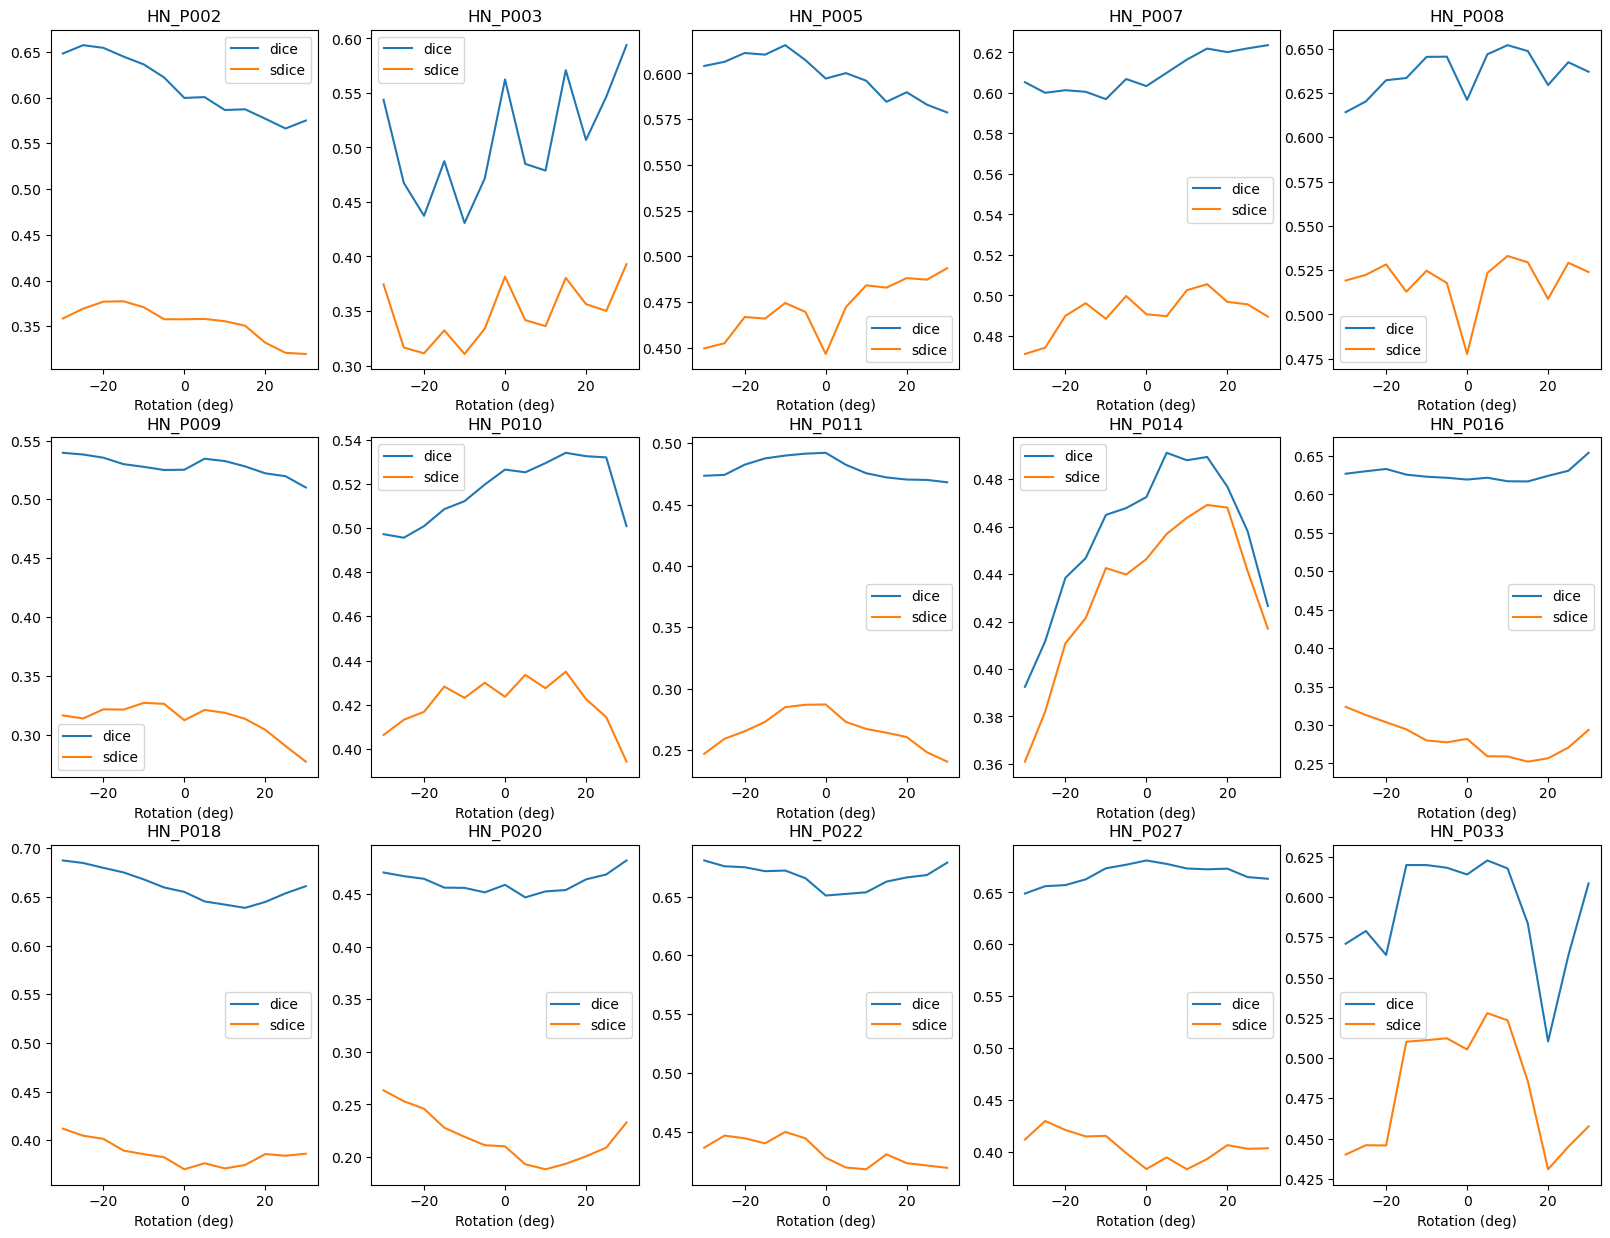

In [13]:
#Dice plots
nrows=3
ncols=5
fig, axes = plt.subplots(nrows, ncols)
fig.set_size_inches(20,15)
index = 0
for i in range(nrows):
    for j in range(ncols):
        patient = short_file_list[index]
        df = pd.DataFrame().assign(dice=dice_table[patient],sdice = sdice_table[patient])
        df.plot(title = patient, ax=axes[i,j], xlabel = 'Rotation (deg)')
        index = index + 1

        

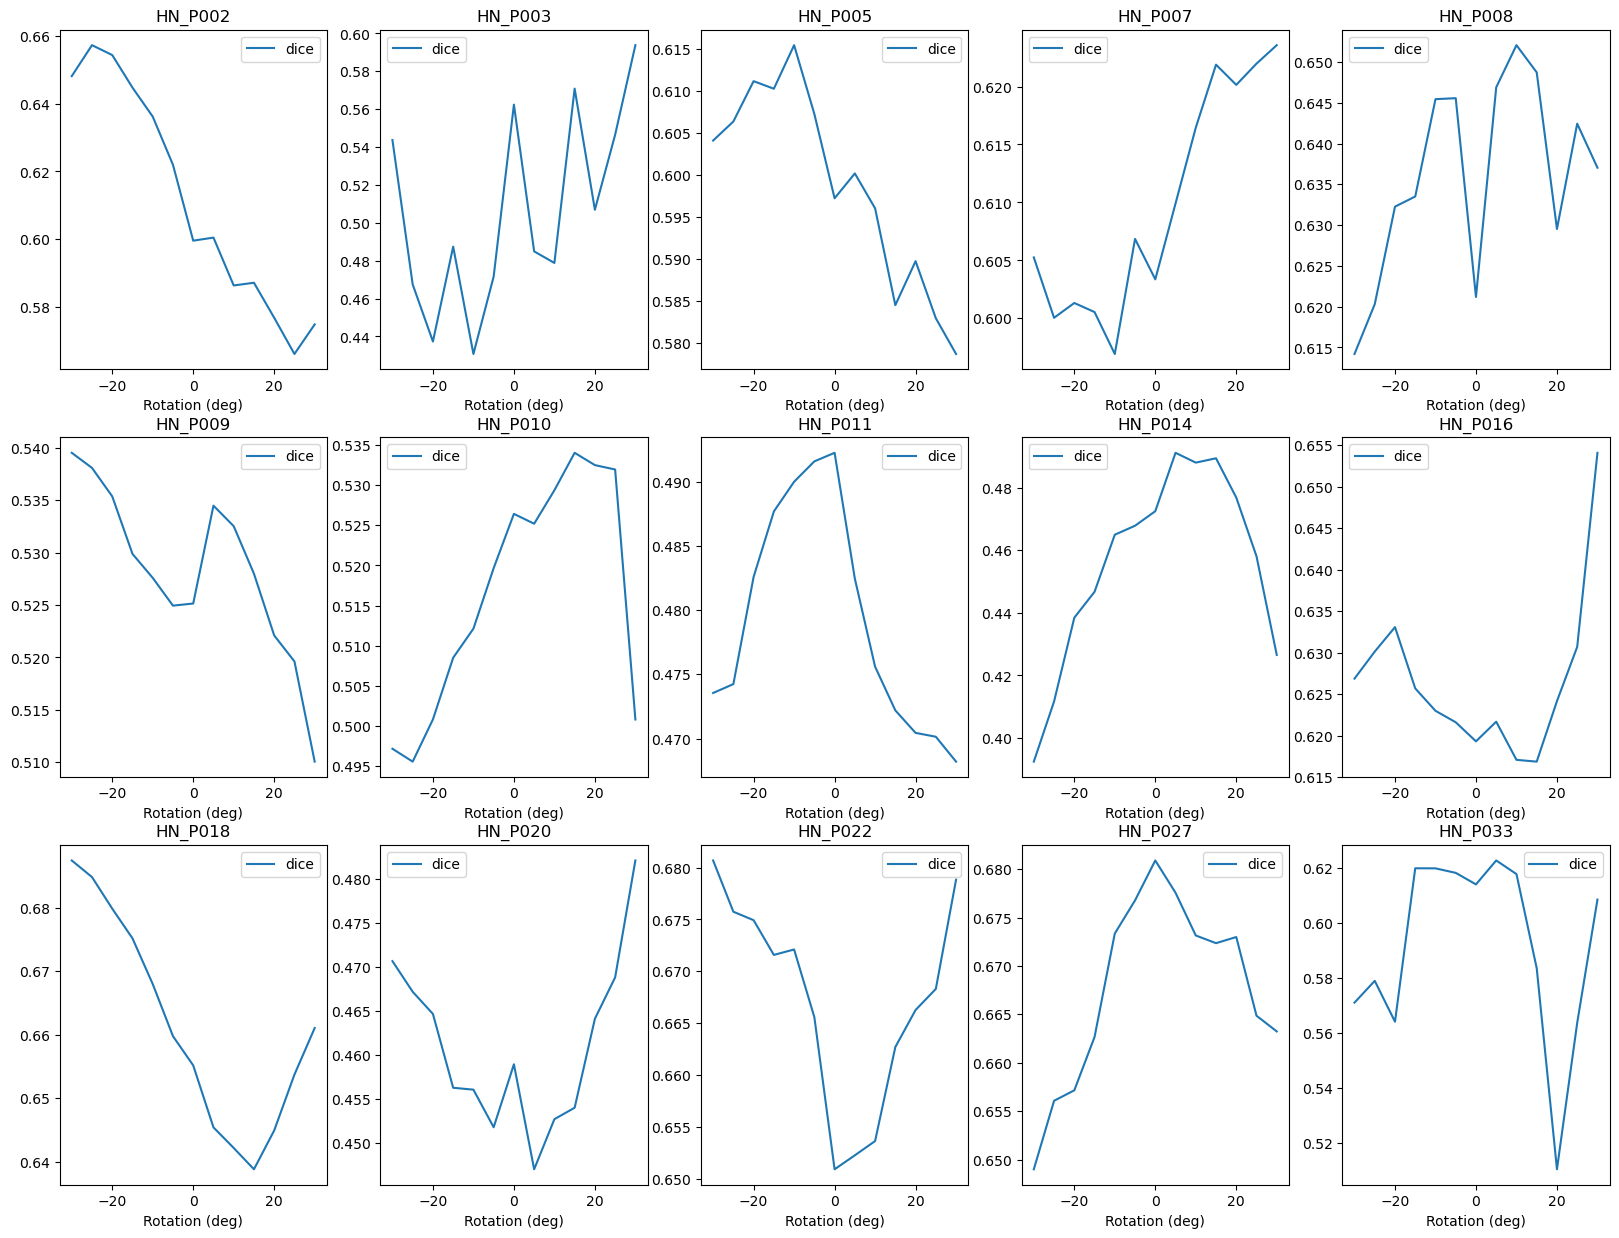

In [14]:
#Dice plots
nrows=3
ncols=5
fig, axes = plt.subplots(nrows, ncols)
fig.set_size_inches(20,15)
index = 0
for i in range(nrows):
    for j in range(ncols):
        patient = short_file_list[index]
        df = pd.DataFrame().assign(dice=dice_table[patient])
        df.plot(title = patient, ax=axes[i,j], xlabel = 'Rotation (deg)')
        index = index + 1

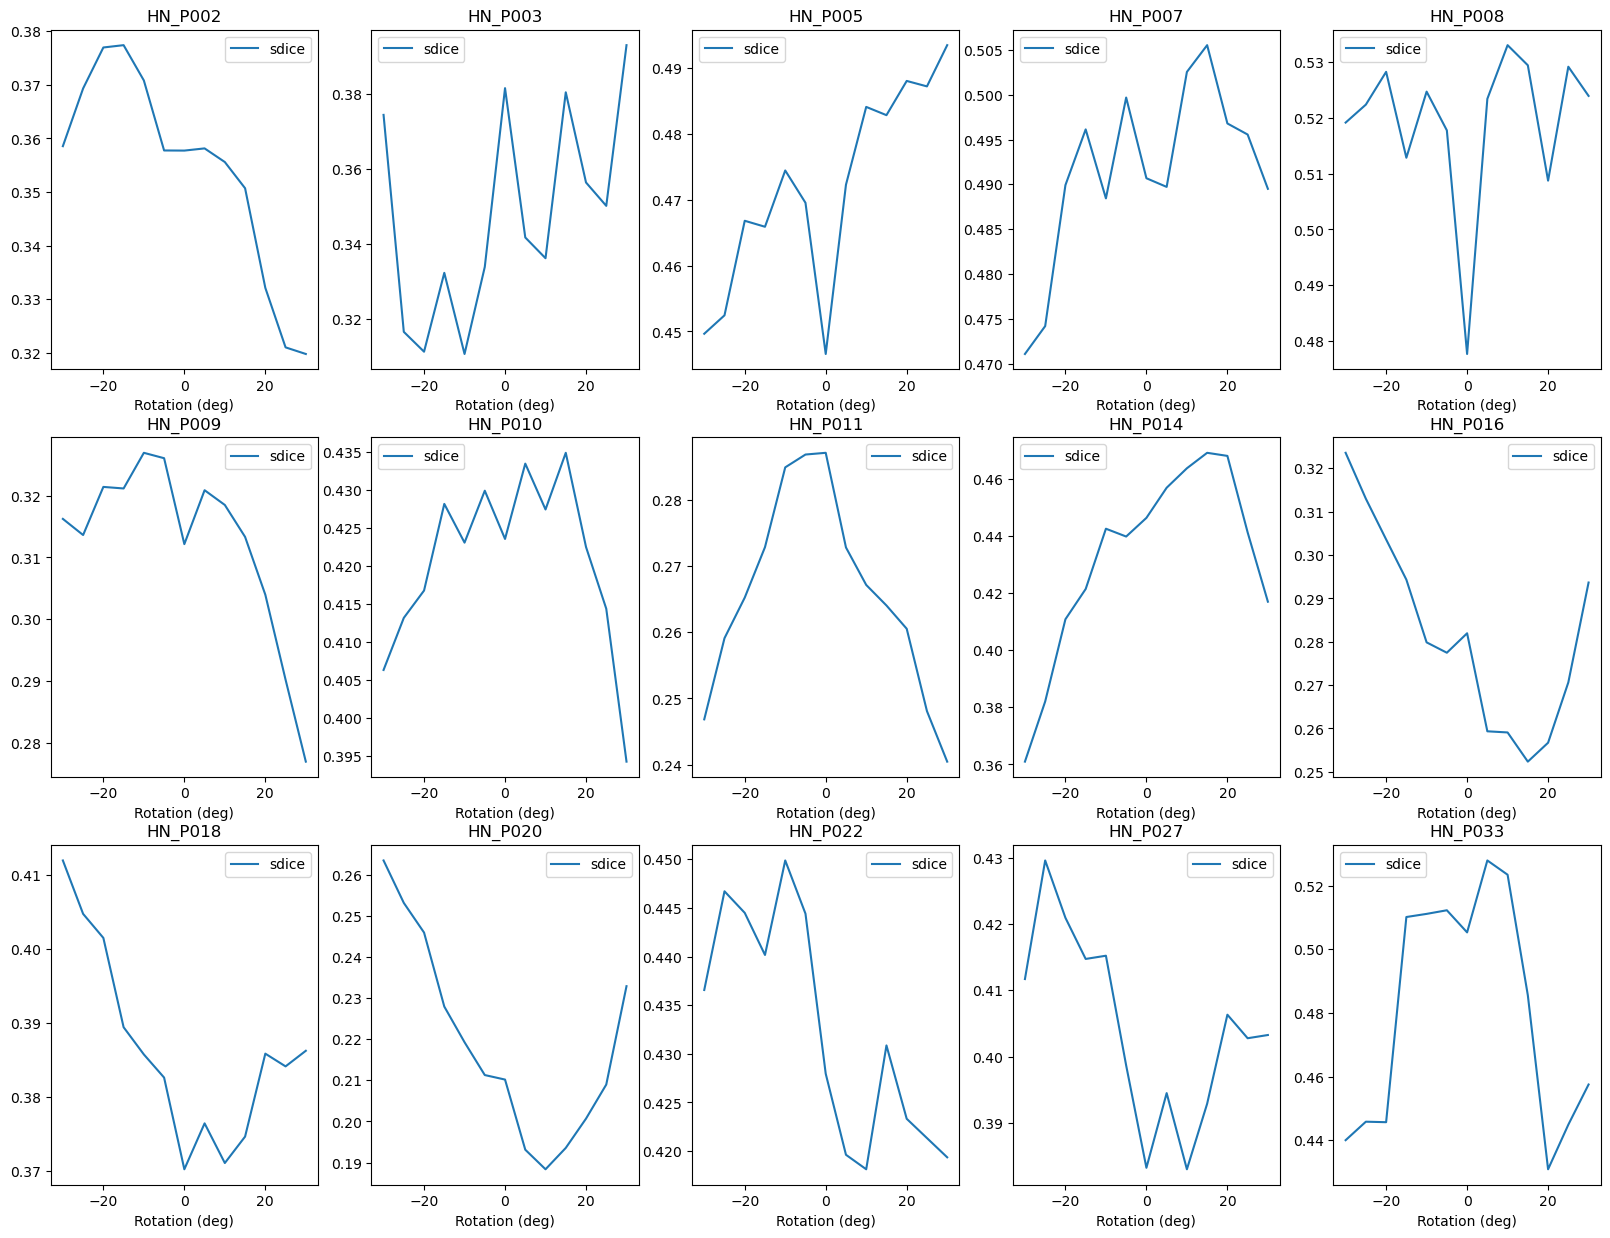

In [15]:
#sDice plots
nrows=3
ncols=5
fig, axes = plt.subplots(nrows, ncols)
fig.set_size_inches(20,15)
index = 0
for i in range(nrows):
    for j in range(ncols):
        patient = short_file_list[index]
        df = pd.DataFrame().assign(sdice=sdice_table[patient])
        df.plot(title = patient, ax=axes[i,j], xlabel = 'Rotation (deg)')
        index = index + 1


Get Max Dice and sDice locations

In [16]:
#Get errors in the table
zero_index = np.floor(len(rot_list)/2)

err_dice_array = dice_array - dice_array[0,:]

err_sdice_array = sdice_array - sdice_array[0,:]

print("Dice Absolute Error:")
abs_err_dice_table = pd.DataFrame(err_dice_array, columns = short_file_list, index=short_rot_list).sort_index().abs()
print(abs_err_dice_table)

print("sDice Absolute Error:")
abs_err_sdice_table = pd.DataFrame(err_sdice_array, columns = short_file_list, index=short_rot_list).sort_index().abs()
print(abs_err_sdice_table)

Dice Absolute Error:
        HN_P002   HN_P003   HN_P005   HN_P007   HN_P008   HN_P009   HN_P010  \
-30.0  0.048519  0.018668  0.006882  0.001891  0.006983  0.014391  0.029232   
-25.0  0.057653  0.094921  0.009155  0.003318  0.000881  0.012952  0.030835   
-20.0  0.054737  0.125079  0.013960  0.002040  0.011073  0.010232  0.025583   
-15.0  0.045131  0.074973  0.013060  0.002822  0.012320  0.004739  0.017905   
-10.0  0.036585  0.131667  0.018252  0.006441  0.024249  0.002448  0.014288   
-5.0   0.022366  0.090791  0.010047  0.003488  0.024368  0.000204  0.006751   
 0.0   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
 5.0   0.000903  0.077483  0.002963  0.006547  0.025703  0.009345  0.001228   
 10.0  0.013207  0.083592  0.001197  0.013088  0.030867  0.007387  0.002938   
 15.0  0.012413  0.008458  0.012737  0.018521  0.027528  0.002847  0.007598   
 20.0  0.022739  0.055517  0.007497  0.016778  0.008339  0.003053  0.006068   
 25.0  0.033420  0.015892  0.01

In [17]:
#Get mean absolute value table
print("Mean Absolute Dice Error:")
MAE_dice_table = abs_err_dice_table.mean(axis = 1)
print(MAE_dice_table)

print("Mean Absolute sDice Error:")
MAE_sdice_table = abs_err_sdice_table.mean(axis = 1)
print(MAE_sdice_table)


Mean Absolute Dice Error:
-30.0    0.023848
-25.0    0.026377
-20.0    0.026774
-15.0    0.017202
-10.0    0.018624
-5.0     0.012525
 0.0     0.000000
 5.0     0.011881
 10.0    0.013760
 15.0    0.012603
 20.0    0.018335
 25.0    0.016097
 30.0    0.021023
dtype: float64
Mean Absolute sDice Error:
-30.0    0.028802
-25.0    0.030210
-20.0    0.027341
-15.0    0.017516
-10.0    0.016869
-5.0     0.012815
 0.0     0.000000
 5.0     0.015271
 10.0    0.017096
 15.0    0.015801
 20.0    0.021376
 25.0    0.022272
 30.0    0.025867
dtype: float64


<Axes: title={'center': 'Mean Absolute Dice Error Across Patient Samples'}, xlabel='Rotation (deg)', ylabel='MAE'>

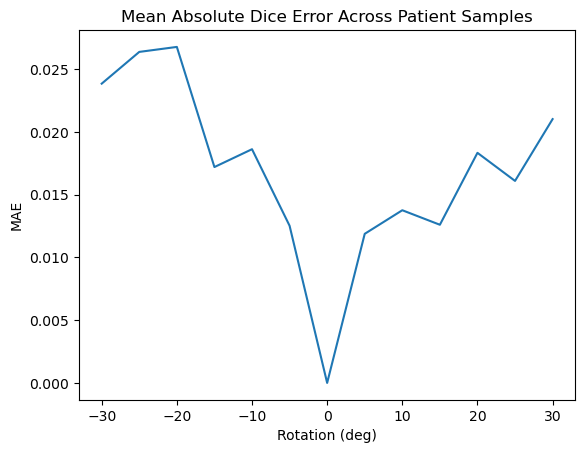

In [18]:
MAE_dice_table.plot(title = 'Mean Absolute Dice Error Across Patient Samples', xlabel = 'Rotation (deg)', ylabel = 'MAE')

<Axes: title={'center': 'Mean Absolute sDice Error Across Patient Samples'}, xlabel='Rotation (deg)', ylabel='MAE'>

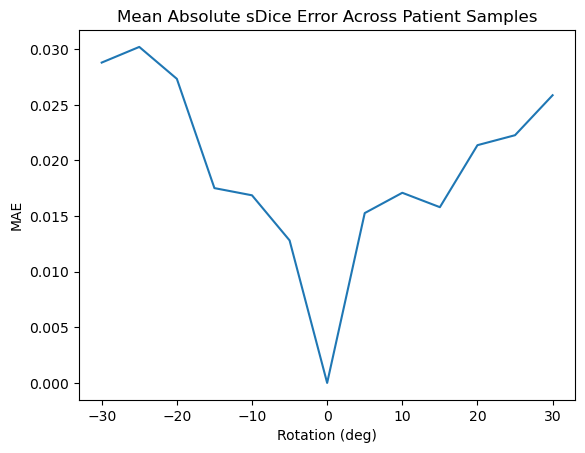

In [19]:
MAE_sdice_table.plot(title = 'Mean Absolute sDice Error Across Patient Samples', xlabel = 'Rotation (deg)', ylabel = 'MAE')

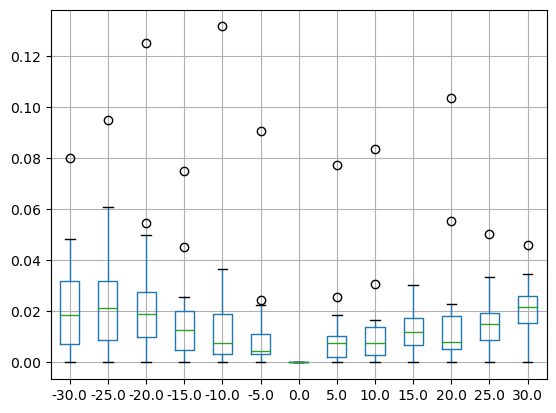

In [29]:
boxplot = abs_err_dice_table.T.boxplot()

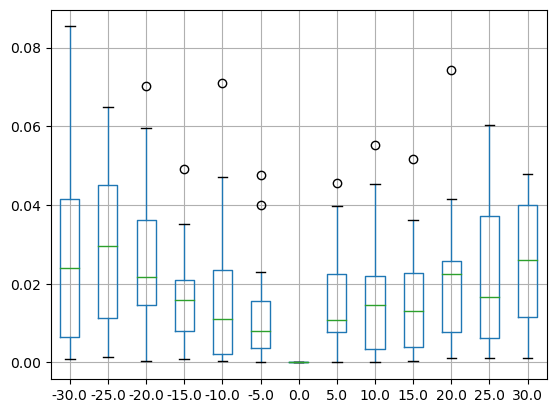

In [24]:
boxplot = abs_err_sdice_table.T.boxplot()